In [62]:
SEED_NUMBER = 1234
from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed
seed(SEED_NUMBER)
set_random_seed(SEED_NUMBER)

import pandas as pd
import numpy as np
import shutil
import time
import matplotlib.pyplot as plt

pd.options.display.max_columns=500
pd.options.display.max_rows=500

# load preprocessed datasets
train = pd.read_csv('./data/processed/train_processed.csv')  
# test = pd.read_csv(PROJ_DIR + 'data/processed/test_processed.csv') 

#### Preprocess: 
See task/process_data.py and Data Processing README.rmd for detailed documentation.
- remove outliers
- impute missing values
- add new features
- dummify categorical features
- bucketize numeric features and dummified

In [2]:
print(train.shape)
print(train.isnull().sum().sum()) # check for no missing value
train.head() # visually inspect dataset. 

(1456, 258)
0


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,IsPool,IsGarage,IsFireplace,TotalFullBath,TotalHalfBath,TotalSF,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,7,5,196.0,8,6,8,6,10,706,0,150,856,10,856,854,0,1710,1,0,2,1,3,1,8,8,0,0,2003.0,4,2,548,6,6,0,61,0,0,0,0,0,208500,0,1,1,3,1,2566,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

### Split train and test

In [3]:
np.random.seed(SEED_NUMBER)
msk = np.random.rand(train.shape[0]) < 0.75
traindf = train[msk]
testdf = train[~msk]
print(traindf.shape)
print(testdf.shape)

train_labels = traindf.pop('SalePrice')
test_labels = testdf.pop('SalePrice')

(1081, 258)
(375, 258)


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
linear_estimator = LinearRegression()
score = cross_val_score(linear_estimator, traindf, train_labels, scoring= 'neg_root_mean_squared_error', cv = 5)
print(f'mean RMSE: {round(np.mean(-score),4)} std: {round(np.std(-score),4)}')

mean RMSE: 31605.0205 std: 3703.582


#### Standard Scaler
Scaling numeric features helps with model generally speaking.

In [5]:
# numeric columns where values range beyond -1 to 1.
SCALE_COLS = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'GarageYrBlt', 'OpenPorchSF', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'TotalFullBath', 'TotalHalfBath', 'TotalSF', 'HeatingQC','BsmtFinType1']


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # default : copy=True, with_mean=True, with_std=True
scaler.fit(traindf[SCALE_COLS]) # we can save scaler if need to be reused in the future or build it into our data preprocessing pipeline.

traindf_s = pd.DataFrame(scaler.transform(traindf[SCALE_COLS]), columns = SCALE_COLS)
testdf_s = pd.DataFrame(scaler.transform(testdf[SCALE_COLS]), columns = SCALE_COLS)

traindf_s = pd.concat([traindf.drop(columns=SCALE_COLS).reset_index(drop=True),traindf_s],axis=1)
testdf_s = pd.concat([testdf.drop(columns=SCALE_COLS).reset_index(drop=True),testdf_s],axis=1)

print(f'training shape: {traindf_s.shape} and test shape: {testdf_s.shape}')
testdf_s.head() # check that scaler worked.

training shape: (1081, 257) and test shape: (375, 257)


,IsPool,IsGarage,IsFireplace,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageYrBlt,OpenPorchSF,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalFullBath,TotalHalfBath,TotalSF,HeatingQC,BsmtFinType1
0,0,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [6]:
from sklearn.linear_model import Lasso
for a in [0.00003, 0.0003, 0.003, 0.03, 0.3, 3, 33, 333, 3333, 33333]:
    linear_estimator = Lasso(alpha = a)
    score = cross_val_score(linear_estimator, traindf_s, train_labels, scoring= 'neg_root_mean_squared_error', cv = 5)
    print(f'Alpha: {a}  --- mean RMSE: {round(np.mean(-score),4)} std: {round(np.std(-score),4)}')

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238742565746.57822, tolerance: 544981588.0845773
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242811135143.09207, tolerance: 528086236.5607174
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227855052363.31198, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

Alpha: 3e-05  --- mean RMSE: 31799.0666 std: 4107.865


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242792280593.63977, tolerance: 528086236.5607174
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227831800422.11984, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261728903676.75754, tolerance: 577630341.2855666
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

Alpha: 0.0003  --- mean RMSE: 31800.1207 std: 4108.6198


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227599037684.4716, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261387888780.65808, tolerance: 577630341.2855666
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218249931200.26587, tolerance: 490576281.53756607
  positive)


Alpha: 0.003  --- mean RMSE: 31805.7085 std: 4117.2196


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234579321130.10455, tolerance: 544981588.0845773
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240724893076.62387, tolerance: 528086236.5607174
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225245031225.06467, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

Alpha: 0.03  --- mean RMSE: 31863.6776 std: 4209.0318


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222540605113.8445, tolerance: 528086236.5607174
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202232826243.15683, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218944763431.1779, tolerance: 577630341.2855666
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did

Alpha: 0.3  --- mean RMSE: 31784.2791 std: 4098.3229


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73974406793.03561, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90611946369.496, tolerance: 577630341.2855666
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71889149411.97882, tolerance: 490576281.53756607
  positive)


Alpha: 3  --- mean RMSE: 31271.334 std: 3578.7981


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4369012024.1033325, tolerance: 544981588.0845773
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1786172035.5714722, tolerance: 528086236.5607174
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7979164187.829712, tolerance: 506797451.7242389
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

Alpha: 33  --- mean RMSE: 30135.5993 std: 3487.8845
Alpha: 333  --- mean RMSE: 28867.4399 std: 3797.4902
Alpha: 3333  --- mean RMSE: 29931.3739 std: 4385.3176
Alpha: 33333  --- mean RMSE: 50808.7454 std: 8431.6263


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4015707618.224121, tolerance: 490576281.53756607
  positive)


#### Best Baseline Model: <b>Lasso Model</b> w/ alpha = 333.
this is a big penalization for large coefficients. Let's see how the lasso model performs on our test dataset.

In [7]:
def test_rmse(prediction):
    # define a function to measure our model performances against test labels.
    score = np.sqrt((test_labels - prediction)**2)
    print(f'***** Mean Test RMSE: {np.mean(score)} *****')

In [8]:
from sklearn.metrics import mean_squared_error
linear_estimator = Lasso(alpha = 333)
linear_estimator.fit(traindf_s, train_labels)
prediction = linear_estimator.predict(testdf_s)
test_rmse(prediction)

***** Mean Test RMSE: 20431.374067946865 *****


Lasso model is also useful for feature selection.

In [9]:
# inspect important features in our linear model.
lasso_features = list(zip(train.columns.tolist(), linear_estimator.coef_.tolist()))

for ele in lasso_features:
    if ele[1] != 0:
        print(ele)

('OverallCond', -1901.3089809055668)
('BsmtFinType1', -826.5201675034626)
('BsmtFinSF2', 1683.8336793933443)
('BsmtFullBath', 109.28387543731333)
('BsmtHalfBath', 4234.343299737338)
('KitchenQual', 3468.4514640565094)
('GarageArea', -2797.626319110486)
('OpenPorchSF', -1228.5372645375087)
('MiscVal', 1277.8460074304014)
('TotalSF', 1233.0186319035236)
('YrBuilt_1929', -943.3087510951019)
('YrBuilt_1990', 20.857215067224054)
('YrBuilt_2000', -5343.802843021725)
('YrBuilt_2009', -885.4140485994425)
('MSSubClass_80', 4973.08958137402)
('Exterior2nd_Other', -2284.4204287445305)
('LotConfig_Mod', 8155.3570259565395)
('PavedDrive_Detchd', 880.1234766829963)
('PavedDrive_None', -610.2535473113455)
('Fence_N', 17933.872727682072)
('Fence_P', 196.66463532765752)
('MasVnrType_GdWo', 185.7796442473466)
('MasVnrType_MnPrv', -4329.028377177413)
('MasVnrType_MnWw', 307.86555736760346)
('MasVnrType_None', 3446.838177036524)
('CentralAir_BrkCmn', 4854.1200741380135)
('CentralAir_BrkFace', 14576.770228

## Neural Network - Keras

Starting from the simplest, let's start with basic nn with only 1 hidden unit.
<br>
X --> 257 (Relu) --> Y

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 2000
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) # plot the train error and validation error.

In [11]:
def build_basic_model(dropout=False):
    set_random_seed(SEED_NUMBER)
    if dropout:
        model = keras.Sequential([
            layers.Dense(len(traindf_s.keys()), activation='relu', input_shape=[len(traindf_s.keys())]),
            layers.Dropout(0.1, seed = 0),
            layers.Dense(1)
    ])
    else:
        model = keras.Sequential([
            layers.Dense(len(traindf_s.keys()), activation='relu', input_shape=[len(traindf_s.keys())]),
            layers.Dense(1)
        ])
    
    optimizer = keras.optimizers.RMSprop(0.01)
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

In [12]:
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               66306     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________


In [53]:
set_random_seed(SEED_NUMBER) # reproducibility

# train model

start_time = time.time()
history = model.fit( 
  traindf_s, train_labels, 
  epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle = False,
  callbacks=[tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+'TRAIN TIME:'+f'{round(time.time()-start_time)}'+'seconds'+'- '*15)
hist = pd.DataFrame(history.history) # training history
hist['epoch'] = history.epoch
hist.tail() # check last few epoch training data.


Epoch: 0, loss:319352665.4815,  root_mean_squared_error:17870.4414,  val_loss:988719315.6129,  val_root_mean_squared_error:31443.9062,  
....................................................................................................
Epoch: 100, loss:293427987.5556,  root_mean_squared_error:17129.7402,  val_loss:997436974.3041,  val_root_mean_squared_error:31582.2246,  
....................................................................................................
Epoch: 200, loss:274984766.5185,  root_mean_squared_error:16582.6641,  val_loss:1005512535.5945,  val_root_mean_squared_error:31709.8164,  
....................................................................................................
Epoch: 300, loss:260113331.2593,  root_mean_squared_error:16128.0273,  val_loss:1010499225.3641,  val_root_mean_squared_error:31788.3496,  
....................................................................................................
Epoch: 400, loss:247332818.9630,  root_

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
1995,7.156605e+07,8459.671875,1.131155e+09,33632.652344,1995
1996,7.144930e+07,8452.768555,1.130955e+09,33629.675781,1996
1997,7.136359e+07,8447.696289,1.131142e+09,33632.453125,1997
1998,7.127434e+07,8442.413086,1.131083e+09,33631.578125,1998
1999,7.115381e+07,8435.271484,1.131224e+09,33633.667969,1999


In [14]:
def plot_errors(test_predictions, title):
    ### plot error distribution
    ### input : predicted values, title of plots.
    ### output: 2 plots: true value vs prediction value, error distribution
    error = test_labels - test_predictions
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].scatter(test_labels, test_predictions) # plot true vs predicted values
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    
    axs[1].hist(error, bins = 40) # error distribution
    axs[1].set_xlabel('Test Prediction Error')
    fig.suptitle(title)

***** Mean Test RMSE: 18645.862395833334 *****


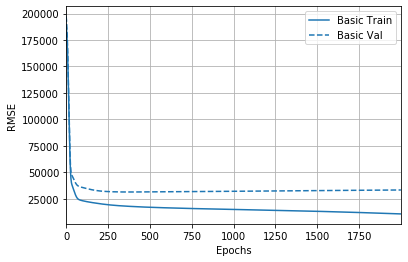

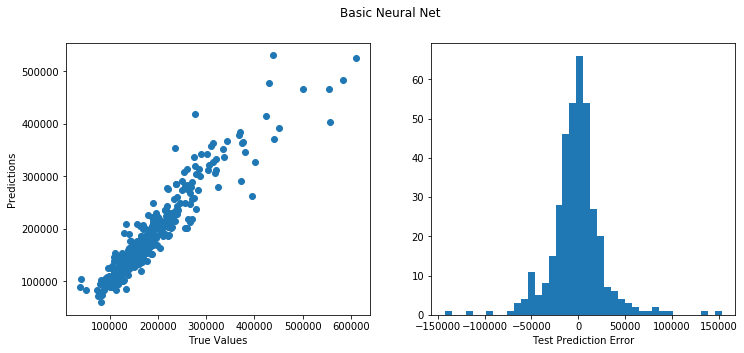

In [15]:
# plotting training progress history
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) 
plotter.plot({'Basic': history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

test_predictions = model.predict(testdf_s).flatten() # predict on test set
test_rmse(test_predictions) # get test set RMSE
plot_errors(test_predictions, title = 'Basic Neural Net') # plot errors.

As you see from above, simple neural net is already performing better than the fine tuned lasso model.
However, the validation error is not decreasing while training error is.
<br>
Training 2000 epochs takes a lot of time and it is not necessarily beneficial.
Let's try using early stopping to stop training when validation error stops decreasing.

### Adding Early Stopping

<br>
X --> 257 (Relu) --> Y


Epoch: 0, loss:37550431725.0370,  root_mean_squared_error:193779.3438,  val_loss:41121499787.2074,  val_root_mean_squared_error:202784.3594,  
....................................................................................................
Epoch: 100, loss:534764861.0370,  root_mean_squared_error:23124.9844,  val_loss:1268635058.4332,  val_root_mean_squared_error:35617.9023,  
....................................................................................................
Epoch: 200, loss:416251282.9630,  root_mean_squared_error:20402.2383,  val_loss:1051927705.3641,  val_root_mean_squared_error:32433.4336,  
....................................................................................................
Epoch: 300, loss:349561174.5185,  root_mean_squared_error:18696.5547,  val_loss:996360917.9724,  val_root_mean_squared_error:31565.1855,  
.................................................................................
- - - - - - - - - - - - - - - TRAIN TIME:41seconds- 

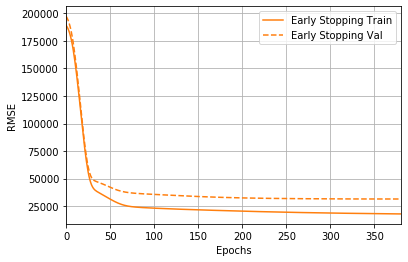

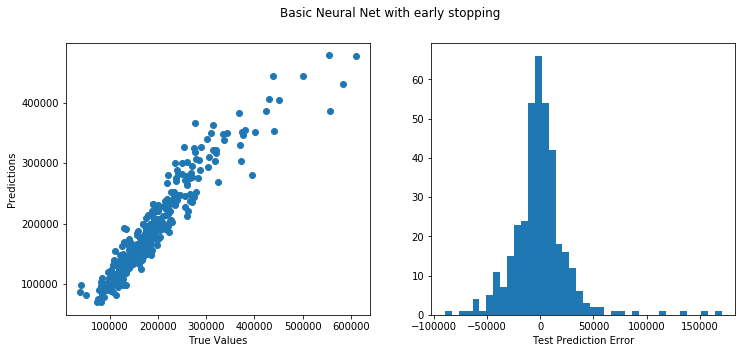

In [59]:
model = build_basic_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()
early_history = model.fit(traindf_s, train_labels, shuffle = False, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+'TRAIN TIME:'+f'{round(time.time()-start_time)}'+'seconds'+'- '*15)
plotter.plot({'Early Stopping': early_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

# predict
test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions) # print test set rmse.
plot_errors(test_predictions, title = 'Basic Neural Net with early stopping') # plot errors.

# Save Model
# model.save('simple_nn_w_early_stop.h5')

So adding early stopping help our model train fast and also improved our result in the test set.
<br>
Next, let's try setting the hidden layer neuron bigger and small to see if that help our model perform better.

### Narrower or  Wider Models

In [26]:
def build_wider_model(N, dropout = False):
    # only have option to drop out for wider models.
    # inputs: wider = True or False
    # narrower = True or False (can put true in wider or narrower but not both)
    # N: number of neurons for the hidden layer.
    # dropout: True or False (it makes sense to try dropout on the wider model.)
    set_random_seed(SEED_NUMBER) # reproducibility

    model = keras.Sequential()
    model.add(layers.Dense(N, activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        model.add(layers.Dropout(0.1, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    
    optimizer = keras.optimizers.RMSprop(0.01)
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

Narrower Model: <br>
recall our basic nn model (X -> 257 -> Y)
<br> Tried N = [50, 100, 150] <br>50 has the best test_prediction rmse, with Mean Test RMSE: 16935.932416


Epoch: 0, loss:37629571147.8519,  root_mean_squared_error:193983.4375,  val_loss:41342750908.7558,  val_root_mean_squared_error:203329.1719,  
....................................................................................................
Epoch: 100, loss:1389497915.2593,  root_mean_squared_error:37275.9688,  val_loss:2181197844.6452,  val_root_mean_squared_error:46703.2969,  
....................................................................................................
Epoch: 200, loss:589233920.0000,  root_mean_squared_error:24274.1406,  val_loss:1353190742.1198,  val_root_mean_squared_error:36785.7422,  
....................................................................................................
Epoch: 300, loss:512185287.7037,  root_mean_squared_error:22631.5117,  val_loss:1239224810.7650,  val_root_mean_squared_error:35202.6250,  
....................................................................................................
Epoch: 400, loss:470961475.5556

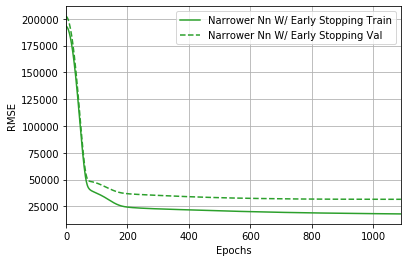

In [58]:
model = build_wider_model(N=50)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 8)

set_random_seed(SEED_NUMBER) # reproducibility

start_time=time.time() # record training time
model_history = model.fit(traindf_s, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=False,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+' TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds ' + '- '*15)
plotter.plot({'Narrower NN w/ early stopping': model_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions)
plot_errors(test_predictions, title='narrower nn')

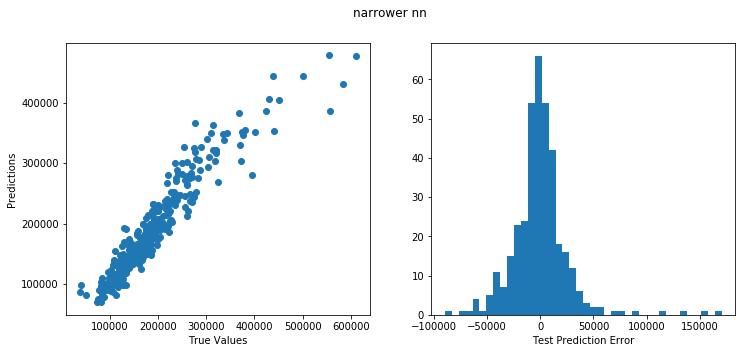

In [60]:
plot_errors(test_predictions, title='narrower nn')

Wider NN without dropout

### wider with dropouts

Wider NN with 500 neurons and dropout rate = 0.1 is the winner so far. Mean Test RMSE: 16919.616416666668


Epoch: 0, loss:37457422487.7037,  root_mean_squared_error:193539.2031,  val_loss:40856332165.3088,  val_root_mean_squared_error:202129.5000,  
....................................................................................................
Epoch: 100, loss:497528311.7037,  root_mean_squared_error:22305.3438,  val_loss:1171709969.8433,  val_root_mean_squared_error:34230.2500,  
....................................................................................................
Epoch: 200, loss:379700600.2963,  root_mean_squared_error:19485.9062,  val_loss:1004823812.7189,  val_root_mean_squared_error:31698.9551,  
...................................................................
- - - - - - - - - - - - - - -  TRAIN TIME:54 seconds - - - - - - - - - - - - - - - 
***** Mean Test RMSE: 16919.616416666668 *****


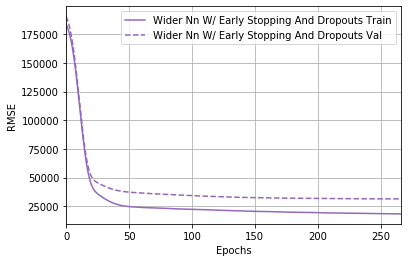

In [61]:
model = build_wider_model(N = 500, dropout=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 15)
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()
model_history = model.fit(traindf_s, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle = False,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+' TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds ' + '- '*15)
plotter.plot({'Wider NN w/ early stopping and dropouts': model_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions)

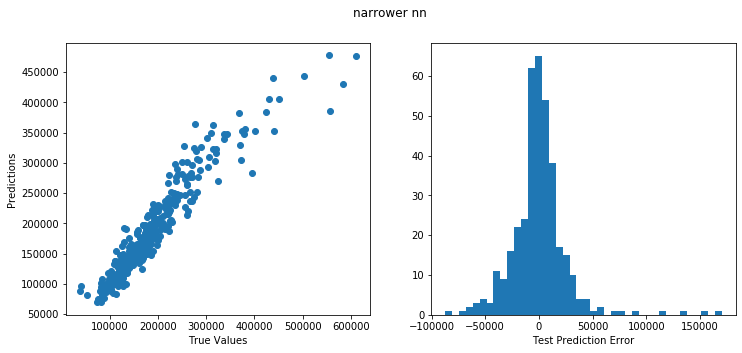

In [63]:
plot_errors(test_predictions, title='narrower nn')

So far we've only built simple NN with 1 hidden layer.
<br>
Let's try deeper NN with more hidden layers to see if they perform better than the simple NN.

### Deeper Models
X -> 500 -> 50 -> Y

In [86]:
def build_deeper_model(dropout=False, rate = 0.15):
    set_random_seed(SEED_NUMBER) # reproducibility
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout: 
        model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    model.add(layers.Dense(50, activation='relu'))
    if dropout: 
        model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    model.add(layers.Dense(1))
    
    
    optimizer = keras.optimizers.RMSprop(0.01)
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model


Epoch: 0, loss:37199783580.4444,  root_mean_squared_error:192872.4531,  val_loss:39713230744.1843,  val_root_mean_squared_error:199281.7812,  
....................................................................................................
- - - - - - - - - - - - - - -  TRAIN TIME:8 seconds - - - - - - - - - - - - - - - 
***** Mean Test RMSE: 17065.97670833333 *****


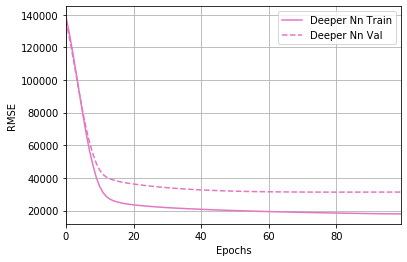

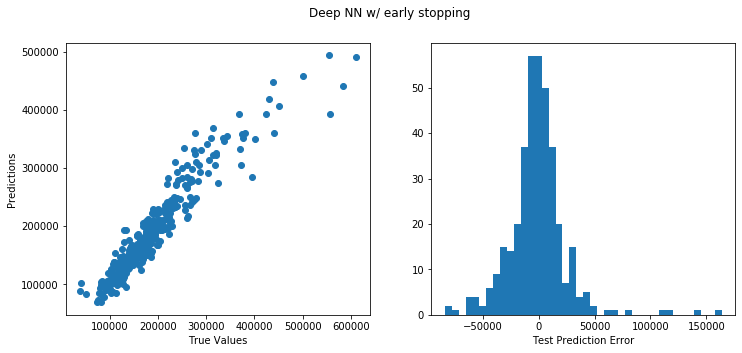

In [99]:
model = build_deeper_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 20)
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()
model_history = model.fit(traindf_s, train_labels, shuffle = False,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 30, #default is 32
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+' TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds ' + '- '*15)
# loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
# print("Eval set Root Mean Squared Error: {:5.2f}".format(rmse))

plotter.plot({'Deeper NN': model_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions)
plot_errors(test_predictions, title = 'Deep NN w/ early stopping')

### Deep NN with dropout
dropout is helpful regularization method for deeper neural nets that helps with overfitting problem.


Epoch: 0, loss:37215220864.0000,  root_mean_squared_error:192912.4844,  val_loss:39786049366.1198,  val_root_mean_squared_error:199464.4062,  
.........................................................................................
- - - - - - - - - - - - - - -  TRAIN TIME:12 seconds - - - - - - - - - - - - - - - 
***** Mean Test RMSE: 17197.949729166667 *****


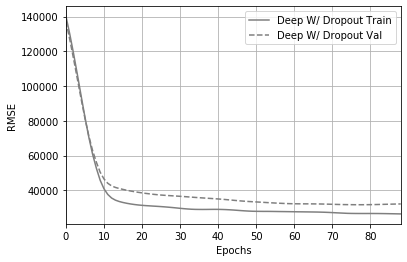

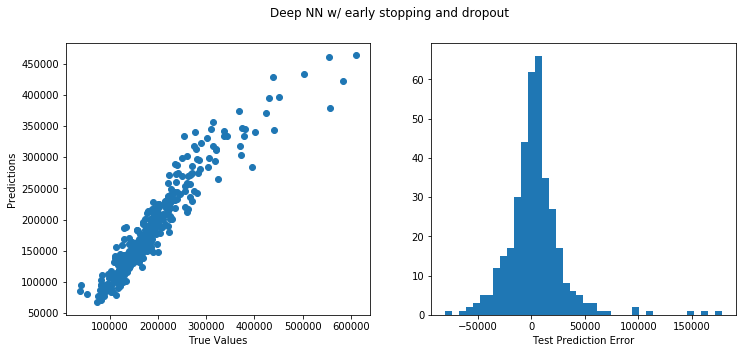

In [103]:
model = build_deeper_model(dropout=True, rate = 0.1) 

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 15) 
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()
early_history = model.fit(traindf_s, train_labels, shuffle = False,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 30,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+' TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds ' + '- '*15)
# loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
# print("Eval set Root Mean Squared Error: {:5.2f}".format(rmse))
plotter.plot({'Deep w/ dropout': early_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')


test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions)
error = test_labels - test_predictions
plot_errors(test_predictions, title = 'Deep NN w/ early stopping and dropout')

In [109]:
def build_5hiddenlayers_model(dropout=False, rate = 0.15, batchnorm=False):
    set_random_seed(SEED_NUMBER) # reproducibility
    if dropout:
        model = keras.Sequential()
        model.add(layers.Dense(len(traindf_s.keys()), activation='relu', input_shape=[len(traindf_s.keys())]))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(rate, seed=SEED_NUMBER))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(128, activation='relu'))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(64, activation='relu'))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(64, activation='relu'))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(32, activation='relu'))
        if dropout:
            layers.Dropout(rate, seed=SEED_NUMBER)
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(1))
    
    optimizer = keras.optimizers.RMSprop(0.01)
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model



Epoch: 0, loss:37648038485.3333,  root_mean_squared_error:194031.0156,  val_loss:41378885197.8617,  val_root_mean_squared_error:203418.0000,  
....................................................................................................
Epoch: 100, loss:25125311928.8889,  root_mean_squared_error:158509.6406,  val_loss:28051926832.3687,  val_root_mean_squared_error:167487.0938,  
....................................................................................................
Epoch: 200, loss:5151773481.7778,  root_mean_squared_error:71775.8516,  val_loss:6429831363.8341,  val_root_mean_squared_error:80186.2266,  
....................................................................................................
Epoch: 300, loss:163475792.7708,  root_mean_squared_error:12785.7656,  val_loss:1227340735.4101,  val_root_mean_squared_error:35033.4258,  
........
- - - - - - - - - - - - - - -  TRAIN TIME:175 seconds - - - - - - - - - - - - - - - 
***** Mean Test RMSE: 18407.66389

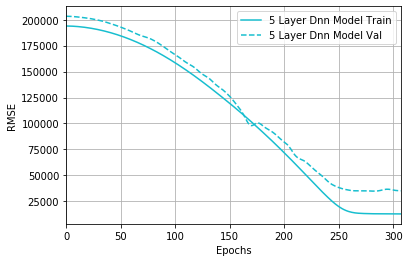

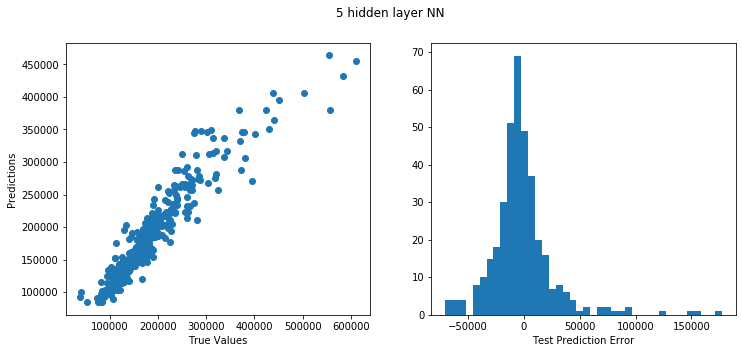

In [114]:
model = build_5hiddenlayers_model(dropout=True, rate = 0.1, batchnorm = True) 

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30) #27
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()
early_history = model.fit(traindf_s, train_labels, shuffle = False,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 30,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
print('\n'+'- '*15+' TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds ' + '- '*15)
# loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
# print("Eval set Root Mean Squared Error: {:5.2f}".format(rmse))
plotter.plot({'5 Layer DNN Model': early_history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

# predict
test_predictions = model.predict(testdf_s).flatten()
test_rmse(test_predictions) # print rmse
plot_errors(test_predictions, title = '5 hidden layer NN')